# Covid Cases Dataset
_____

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [144]:
df_cases = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
df_cases = df_cases[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
df_cases.head()

,submission_date,state,tot_cases,new_case,tot_death,new_death
0,01/25/2020,OR,0,0,0,0
1,09/17/2021,MD,"516,784","1,525","10,282",11
2,10/12/2021,VT,"33,388",112,333,4
3,02/01/2021,DC,"37,008",136,916,3
4,12/19/2021,NC,"1,586,243","3,410","19,480",19


In [145]:
df_cases['submission_date'] = pd.to_datetime(df_cases['submission_date'])

In [146]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59640 entries, 0 to 59639
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   submission_date  59640 non-null  datetime64[ns]
 1   state            59640 non-null  object        
 2   tot_cases        59640 non-null  object        
 3   new_case         59640 non-null  object        
 4   tot_death        59640 non-null  object        
 5   new_death        59640 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.7+ MB


In [147]:
df_cases.set_index('submission_date', inplace=True)
df_cases.sort_index(inplace=True)

In [148]:
df_cases.columns

Index(['state', 'tot_cases', 'new_case', 'tot_death', 'new_death'], dtype='object')

In [149]:
df_cases['tot_cases'].value_counts()

0            4117
4             578
1             280
3             195
2             161
             ... 
401,591         1
526,423         1
815,593         1
621,542         1
7,135,916       1
Name: tot_cases, Length: 42844, dtype: int64

In [150]:
df_cases['new_case'].value_counts()

0         14040
1           346
2           277
3           185
4           167
          ...  
13,181        1
10,421        1
21,940        1
16,373        1
5,470         1
Name: new_case, Length: 8121, dtype: int64

In [151]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    df_cases[c] = df_cases[c].map( lambda x: x.replace(',','')).astype(int)
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [152]:
df_cases[df_cases['tot_cases']==0].count()

state        4117
tot_cases    4117
new_case     4117
tot_death    4117
new_death    4117
dtype: int64

In [153]:
df_cases.drop(df_cases[df_cases['tot_cases']==0].index, inplace=True)

In [154]:
df_cases.shape

(23220, 5)

In [155]:

df_cases.head(70)


,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2021-09-20,RI,160838,301,2814,0
2021-09-20,OH,1352104,4899,21471,0
2021-09-20,MO,803750,1997,11276,213
2021-09-20,MD,520236,1139,10332,18
2021-09-20,VT,29573,90,294,1
...,...,...,...,...,...
2021-09-21,MP,265,0,2,0
2021-09-21,OK,600800,2243,8743,25
2021-09-21,HI,73841,274,709,0


In [156]:
df = df_cases.copy()
df.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2021-09-20,RI,160838,301,2814,0
2021-09-20,OH,1352104,4899,21471,0
2021-09-20,MO,803750,1997,11276,213
2021-09-20,MD,520236,1139,10332,18
2021-09-20,VT,29573,90,294,1


In [157]:
df = df.groupby(by=df.index).sum()
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2021-09-20,42247951,98596,683689,1334
2021-09-21,42381431,132856,686045,2347
2021-09-22,42514457,132581,688408,2293
2021-09-23,42653168,137245,690489,2057
2021-09-24,42786272,132747,692963,2413


In [158]:
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 387 entries, 2021-09-20 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  387 non-null    int64
dtypes: int64(1)
memory usage: 6.0 KB


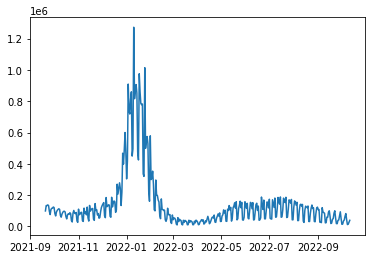

In [160]:
plt.plot(df['new_case'])

In [161]:
df = df.resample('W').mean()
df.head()

,new_case
submission_date,
2021-09-26,115027.142857
2021-10-03,104485.142857
2021-10-10,93047.571429
2021-10-17,80260.285714
2021-10-24,65884.142857


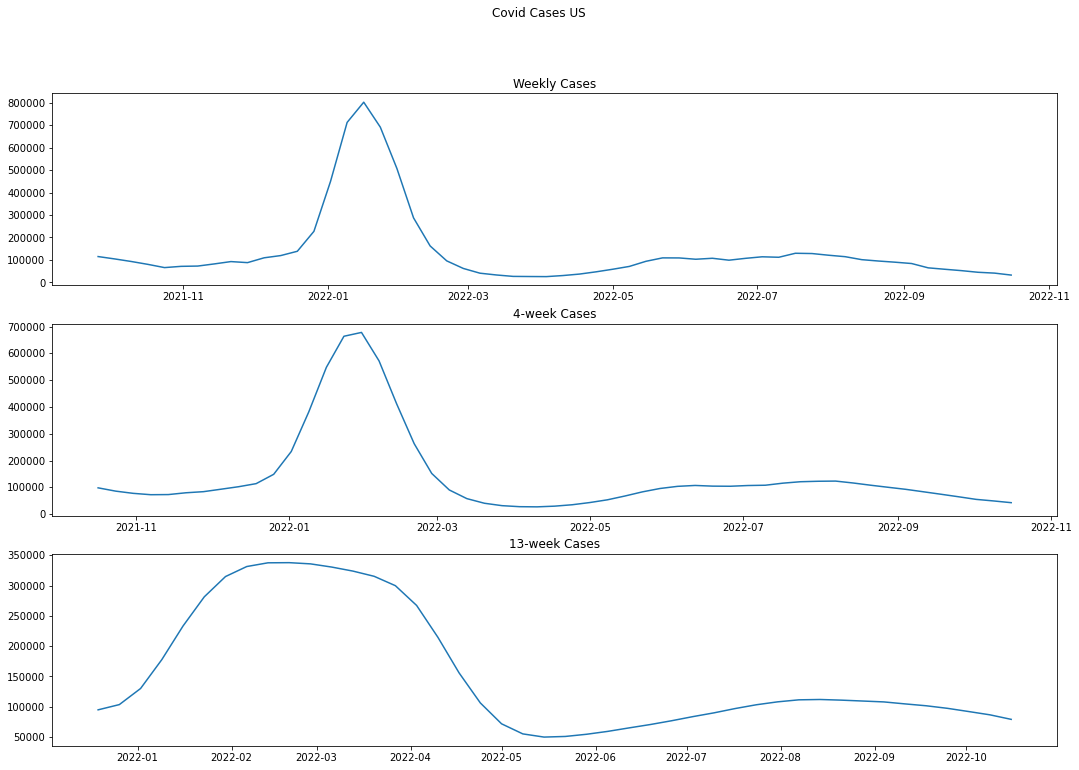

In [162]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()

fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])


fig.suptitle('Covid Cases US')
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')



In [163]:
df.dropna(inplace=True)
df.head()

,new_case,moving_average_1,moving_average_4,moving_average_13
submission_date,,,,
2021-12-19,138558.142857,138558.142857,113871.071429,94870.417582
2021-12-26,227317.857143,227317.857143,148699.642857,103508.164835
2022-01-02,449677.714286,449677.714286,233745.714286,130061.439560
2022-01-09,712209.000000,712209.000000,381940.678571,177689.241758
2022-01-16,802153.857143,802153.857143,547839.607143,233219.516484


Text(0, 0.5, 'Number of Cases')

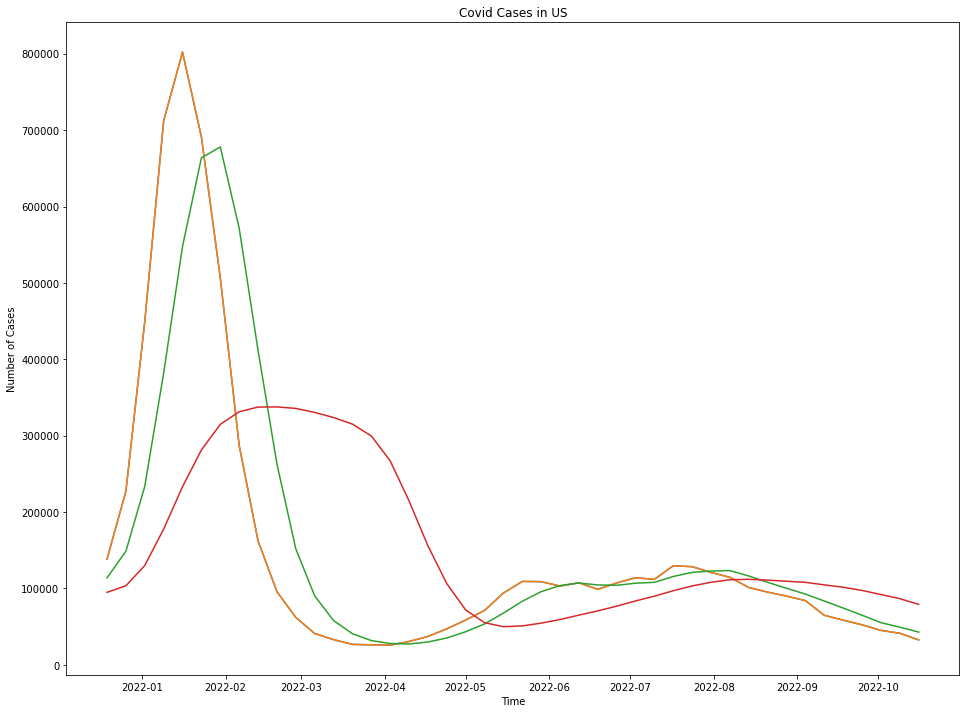

In [164]:
plt.figure(figsize=(16,12))
plt.plot(df)
plt.title('Covid Cases in US')
plt.xlabel('Time')
plt.ylabel('Number of Cases')

# Cases by State
____

In [174]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2021-09-20,RI,160838,301,2814,0
2021-09-20,OH,1352104,4899,21471,0
2021-09-20,MO,803750,1997,11276,213
2021-09-20,MD,520236,1139,10332,18
2021-09-20,VT,29573,90,294,1


In [176]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,83883567,185258,419657,730
AL,464181671,760551,7197272,5751
AR,294114065,469668,4045569,4583
AS,1381831,8250,5776,34
AZ,706063765,1208432,10585383,12131
CA,3231201558,6646885,32637595,27806
CO,500478310,1004957,4390861,5956
CT,265997933,502857,3970921,2922
DC,48787589,109435,502811,216


In [189]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23220 entries, 2021-09-20 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      23220 non-null  object
 1   tot_cases  23220 non-null  int64 
 2   new_case   23220 non-null  int64 
 3   tot_death  23220 non-null  int64 
 4   new_death  23220 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ MB


In [199]:
df_cases.head(60).sort_values(by='state')

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2021-09-20,AK,98061,687,459,3
2021-09-20,AL,771011,3243,14805,58
2021-09-20,AR,485452,568,7482,24
2021-09-20,AS,1,1,0,0
2021-09-20,AZ,1068823,2020,19513,0
2021-09-20,CA,4622180,6193,67612,4
2021-09-20,CO,657162,1290,7405,13
2021-09-20,CT,385788,484,8462,-1
2021-09-20,DC,59563,238,1170,3


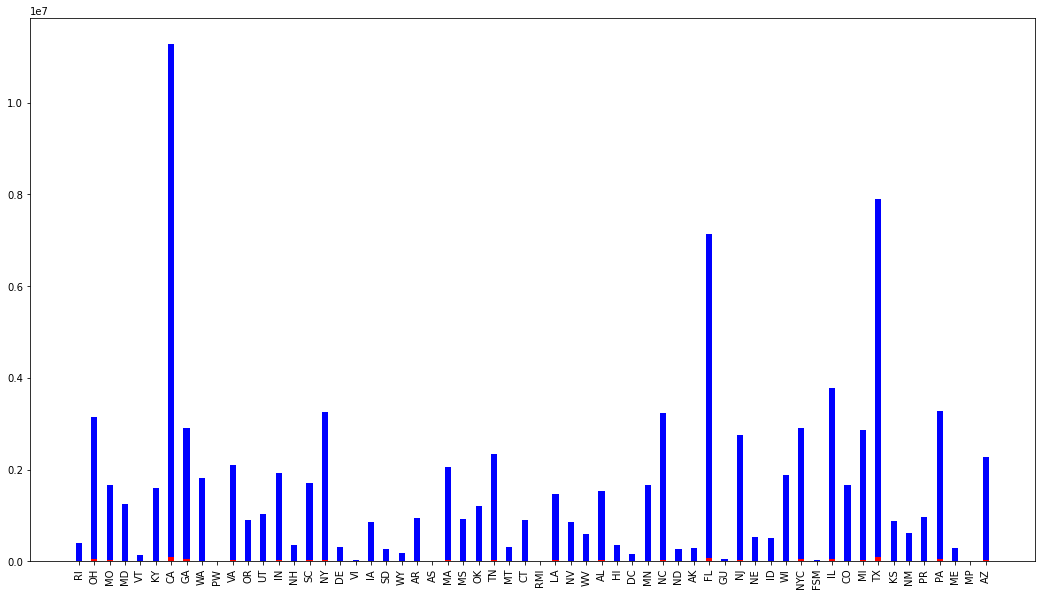

In [195]:
from turtle import color

from sympy import rotations

df_cases.head()
# create data
plt.figure(figsize=(18,10))
x = df_cases['state']
y1 = df_cases['tot_cases']
y2 = df_cases['tot_death']
width = 0.40
  
# plot data in grouped manner of bar type
plt.bar(x, y1, width, color='b')
plt.bar(x, y2, width, color='r')
plt.xticks(rotation=90);


In [183]:
df_cases.groupby(by='state').sum().T

state,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
tot_cases,83883567,464181671,294114065,1381831,706063765,3231201558,500478310,265997933,48787589,92381707,...,720772175,2396165209,327175119,601591456,6027896,37038339,515142965,565648846,174780882,56019052
new_case,185258,760551,469668,8250,1208432,6646885,1004957,502857,109435,184276,...,1140830,3865554,546900,1271929,16630,103769,1198467,1098761,380139,92651
tot_death,419657,7197272,4045569,5776,10585383,32637595,4390861,3970921,502811,1057562,...,9053823,31456906,1669852,7070436,40435,211841,4519659,5027222,2385224,638655
new_death,730,5751,4583,34,12131,27806,5956,2922,216,1096,...,11025,28560,2231,9744,56,405,7170,6612,4200,986


In [ ]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

# Vacination data
____


In [165]:
df_vacc=pd.read_csv('../data/covid_vaccination_trends.csv', low_memory=False)
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74160 entries, 0 to 74159
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Date                                         74160 non-null  object 
 1   date_type                                    74160 non-null  object 
 2   MMWR_week                                    74160 non-null  int64  
 3   Location                                     74160 non-null  object 
 4   Administered_Daily                           74160 non-null  object 
 5   Administered_Cumulative                      74160 non-null  object 
 6   Administered_7_Day_Rolling_Average           73140 non-null  object 
 7   Admin_Dose_1_Daily                           74160 non-null  object 
 8   Admin_Dose_1_Cumulative                      74160 non-null  object 
 9   Admin_Dose_1_Day_Rolling_Average             73140 non-null  object 
 10

In [166]:
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)


In [167]:
df_vacc.columns

Index(['date_type', 'MMWR_week', 'Location', 'Administered_Daily',
       'Administered_Cumulative', 'Administered_7_Day_Rolling_Average',
       'Admin_Dose_1_Daily', 'Admin_Dose_1_Cumulative',
       'Admin_Dose_1_Day_Rolling_Average', 'Administered_Dose1_Pop_Pct',
       'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily', 'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct'],
      dtype='object')

In [168]:
df_vacc.drop(columns=['date_type','MMWR_week'],inplace=True)
df_vacc

,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,GU,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,FM,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,MA,2,2,2,22,22,22,0.0,2,2,...,4,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,NY,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0,0.0,0,0,0,0.0
2020-12-13,AZ,"4,423","4,423","4,423","3,116","3,116","3,116",0.0,"4,423","4,423",...,"1,097",0.0,0,0,0,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-12,AS,42,"114,422",NaN,7,"46,004",NaN,95.0,NaN,NaN,...,NaN,89.5,16,"24,539",NaN,57.9,12,"2,030",NaN,24.3
2022-10-12,RI,"20,905","2,447,927",NaN,"3,397","1,095,356",NaN,95.0,NaN,NaN,...,NaN,85.9,"2,067","515,043",NaN,56.6,"5,104","120,835",NaN,40.7
2022-10-12,AL,"18,544","6,649,782",NaN,"2,490","3,148,955",NaN,64.2,NaN,NaN,...,NaN,52.4,"2,835","983,521",NaN,38.3,"5,307","194,224",NaN,27.1


In [169]:
df_vacc.drop(columns=['Administered_Daily', 'Administered_Cumulative',
       'Administered_7_Day_Rolling_Average', 'Admin_Dose_1_Daily', 'Admin_Dose_1_Day_Rolling_Average',
       'Administered_Dose1_Pop_Pct', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily', 'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct'],inplace=True)


In [170]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74160 entries, 2020-12-13 to 2022-10-12
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Location                 74160 non-null  object
 1   Admin_Dose_1_Cumulative  74160 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [171]:
df_vacc['Admin_Dose_1_Cumulative'] = df_vacc['Admin_Dose_1_Cumulative'].map( lambda x: x.replace(',','')).astype(int)
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74160 entries, 2020-12-13 to 2022-10-12
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Location                 74160 non-null  object
 1   Admin_Dose_1_Cumulative  74160 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [172]:
df_vacc = df_vacc.groupby(by=df_vacc.index).sum()
df_vacc.head()

,Admin_Dose_1_Cumulative
Date,
2020-12-13,63478
2020-12-14,72612
2020-12-15,164862
2020-12-16,474783
2020-12-17,1009666


In [173]:
df_vacc.head(70)

,Admin_Dose_1_Cumulative
Date,
2020-12-13,63478
2020-12-14,72612
2020-12-15,164862
2020-12-16,474783
2020-12-17,1009666
...,...
2021-02-16,159035888
2021-02-17,162004921
2021-02-18,165071278
